# Bike Sharing Demand

## CRISP-DM Approach

CRISP-DM stands for Cross-Industry Standard Process for Data Mining and describes a structured approach to understanding, preparing, modeling and evaluating data. This process includes the following steps:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Deployment is not relevant for this type of project, as I won't be deploying my model to a web server. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

### 2. Data Understanding

The data set is similar to the bike sharing dataset provided by the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). However, the aforementioned dataset only contains data for 2011 and 2012. It was originally created by Fanaee-T and Gama (2013) in their study ["Event labeling combining ensemble detectors and background knowledge"](https://link.springer.com/article/10.1007/s13748-013-0040-3). 

To have a larger dataset, I collected the following data from the following sources for the time period of January 1, 2011 until December 31, 2018:
* The bike demand data comes from [Capital Bike Share](http://capitalbikeshare.com/system-data)
* The weather data was taken from [NOAA's National Climatic Data Center](https://www.ncdc.noaa.gov/cdo-web/search)
* The holiday data is from the [DC Department of Human Resources](http://dchr.dc.gov/page/holiday-schedule). 

The dataset uses data from the bike sharing stations of Capital Bike Share in Washington, D.C., USA. The weather data and holiday data refer to the same location.


In [242]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_validate, TimeSeriesSplit


import seaborn as sb
import matplotlib.pyplot as plt 

%matplotlib inline


#### 2.1. Loading the data and visualizing and describing it

In [243]:
# read in bike sharing dataset
bike_df = pd.read_csv('bike_sharing_dataset.csv')
bike_df.head()


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


In [244]:
# print descriptive statistics
bike_df.describe()


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
count,2101.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,1503.0,208.0,694.0,129.0,...,5.0,84.0,36.0,10.0,4.0,1.0,2918.000000,2918.000000,2918.000000,89.0
mean,14.419007,8.506468,19.015689,11.069243,3.435734,3.162898,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1679.776217,6046.297121,7726.073338,1.0
std,9.556401,9.473941,9.835524,9.481232,8.183658,1.379582,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,1560.762932,2756.888032,3745.220092,0.0
min,-12.100000,-16.993750,-7.980000,-15.658333,0.000000,0.375000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.000000,19.000000,21.000000,1.0
25%,6.566667,0.516538,11.081562,3.013068,0.005510,2.200000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,512.250000,3839.250000,4628.500000,1.0
50%,15.433333,8.504911,19.992857,11.619091,0.271504,2.900000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1220.500000,5964.000000,7442.500000,1.0
75%,23.066667,17.338393,27.874583,19.767083,2.885381,3.875000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2357.250000,8187.500000,10849.500000,1.0
max,31.733333,26.206250,37.850000,28.666667,118.789796,12.750000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,10173.000000,15419.000000,19113.000000,1.0


In [245]:
# check the datatypes of each variable
bike_df.dtypes


date                  object
temp_avg             float64
temp_min             float64
temp_max             float64
temp_observ          float64
precip               float64
wind                 float64
wt_fog               float64
wt_heavy_fog         float64
wt_thunder           float64
wt_sleet             float64
wt_hail              float64
wt_glaze             float64
wt_haze              float64
wt_drift_snow        float64
wt_high_wind         float64
wt_mist              float64
wt_drizzle           float64
wt_rain              float64
wt_freeze_rain       float64
wt_snow              float64
wt_ground_fog        float64
wt_ice_fog           float64
wt_freeze_drizzle    float64
wt_unknown           float64
casual               float64
registered           float64
total_cust           float64
holiday              float64
dtype: object

In [246]:
bike_df.head()

,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,330.0,629.0,959.0,NaN
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,130.0,651.0,781.0,NaN
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,120.0,1181.0,1301.0,NaN
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,107.0,1429.0,1536.0,NaN
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82.0,1489.0,1571.0,NaN


Based on the source repository of the data set, these are the meanings of each variable:
- date: date
- temp_avg: average temperature in Celcius
- temp_min: minimum temperature in Celcius
- temp_max: maximum temperature in Celcius
- temp_observ: temperature at time of observation
- precip: precipitation in mm 
- wind: average windspeed
- wt: weather types
    - fog: fog, ice fog, or freezing fog (may include heavy fog)
    - heavy_fog: heavy fog or heaving freezing fog (not always distinguished from fog)
    - thunder: thunder
    - sleet: ice pellets, sleet, snow pellets, or small hail
    - hail: hail (may include small hail)
    - glaze: glaze or rime
    - haze: smoke or haze
    - drift_snow: blowing or drifting snow 
    - high_wind: high or damaging winds
    - mist: mist
    - drizzle: drizzle
    - rain: rain (may include freezing rain, drizzle, and freezing drizzle)
    - freeze_rain: freezing rain
    - snow: snow, snow pellets, snow grains, or ice crystals
    - ground_fog: ground fog
    - ice_fog: ice for or freezing fog
    - freeze_drizzle: freezing drizzle
    - unknown: unknown source of precipitation
- casual: count of casual users
- registered: count of registered users
- total_cust: count of total rental bikes including both casual and registered
- holiday: holiday in Washington D.C.


##### Checking for and dealing with missing values

In [247]:
# Check for missing values
bike_df.isnull().sum()


date                    0
temp_avg              821
temp_min                0
temp_max                0
temp_observ             0
precip                  0
wind                    0
wt_fog               1419
wt_heavy_fog         2714
wt_thunder           2228
wt_sleet             2793
wt_hail              2872
wt_glaze             2769
wt_haze              2217
wt_drift_snow        2915
wt_high_wind         2664
wt_mist              2551
wt_drizzle           2794
wt_rain              2516
wt_freeze_rain       2917
wt_snow              2838
wt_ground_fog        2886
wt_ice_fog           2912
wt_freeze_drizzle    2918
wt_unknown           2921
casual                  4
registered              4
total_cust              4
holiday              2833
dtype: int64

The feature **temp_avg** is missing 821 values. I will use the temp_min, temp_max and temp_observ features to estimate the missing temp_avg values. There are also 4 values missing for **casual, registered and total_cust features** and the target, respectively. I will check why these are missing and exclude those observations because if the target variable is missing, I cannot estimate it. 

The **holiday** feature has NAs but these should actually 0s, which I will convert. The **wt_** features also have NAs where 0s should be which I will insert.


In [248]:
# fill NAs with 0 where applicable
wt_feats = [x for x in bike_df.columns if 'wt' in x]
bike_df['holiday'] = bike_df['holiday'].fillna(0)
bike_df[wt_feats] = bike_df[wt_feats].fillna(0)


In [249]:
# check casual, registered and total_cust missing rows
bike_df[bike_df['casual'].isna()]


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
1848,2016-01-23,-4.366667,-6.128571,-2.392857,-4.688889,42.045946,8.08,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1849,2016-01-24,-2.666667,-7.985714,-1.028571,-6.366667,19.339130,3.75,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1850,2016-01-25,-5.133333,-11.128571,2.028571,-9.877778,0.000000,1.15,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1851,2016-01-26,2.333333,-7.871429,7.471429,3.588889,0.000000,2.85,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


There seem to be four days where no data was captured for the rented bikes. Because this is a time series, I am not sure whether I can drop these rows or whether I should interpolate the target values for these four days. More research is necessary to determine this.

In [251]:
# dropping rows with missing target label
bike_df.dropna(subset=['total_cust'], inplace=True)


In [252]:
# which rows have the average temperature missing
bike_df[bike_df['temp_avg'].isna()] # all rows between 0 and 820


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,330.0,629.0,959.0,0.0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,130.0,651.0,781.0,0.0
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,120.0,1181.0,1301.0,0.0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,107.0,1429.0,1536.0,0.0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,82.0,1489.0,1571.0,0.0
5,2011-01-06,NaN,-4.993333,4.233333,-4.245455,0.000000,1.600,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,88.0,1485.0,1573.0,0.0
6,2011-01-07,NaN,-3.885714,2.857143,-1.570000,0.101205,2.550,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,148.0,1345.0,1493.0,0.0
7,2011-01-08,NaN,-3.980000,0.486667,-2.472727,0.285057,4.575,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,68.0,871.0,939.0,0.0
8,2011-01-09,NaN,-6.293333,0.226667,-6.072727,0.283529,6.425,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,54.0,748.0,802.0,0.0
9,2011-01-10,NaN,-6.238462,0.507692,-5.177778,0.000000,2.975,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,41.0,1257.0,1298.0,0.0


In [253]:
# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# I'm excluding the first 820 rows because they contain missing temp_avg values
print('temp_avg:', pearsonr(bike_df['temp_avg'][821:], bike_df['total_cust'][821:]))

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(bike_df['temp_min'], bike_df['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(bike_df['temp_min'][821:], bike_df['total_cust'][821:]))

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(bike_df['temp_max'], bike_df['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(bike_df['temp_max'][821:], bike_df['total_cust'][821:]))

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(bike_df['temp_observ'], bike_df['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(bike_df['temp_observ'][821:], bike_df['total_cust'][821:]))


temp_avg: (0.7274580830939563, 0.0)
temp_min: (0.5471267612970498, 1.4921092863545504e-227)
temp_min, without first 820 rows: (0.6701630736430086, 1.4903096488706592e-273)
temp_max: (0.5951721674508469, 3.077604133019838e-279)
temp_max, without first 820 rows: (0.7392634407482874, 0.0)
temp_observ: (0.5488924647427227, 2.636595309264676e-229)
temp_observ, without first 820 rows: (0.6789481741748534, 1.8760440539901342e-283)


The above shows that disregarding the first 820 rows leads to the highest correlation between temp_max and total_cust. However, comparing temp_avg with the entire dataset and the respective correlations with total_cust, temp_avg has the highest correlation. I will estimate the missing temp_avg figures and see how the correlation changes and decide how to proceed.

In [254]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    # create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1 
                                                     if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1 
                                                     if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1 
                                                     if '09' in x[5:7] else 0)
    df['season_winter'] = df['date'].apply(lambda x: 1 if '10' in x[5:7] else 1 if '11' in x[5:7] else 1 
                                                     if '12' in x[5:7] else 0)
    
    return df


In [255]:
# estimating average temperature for observations that currently have NAs in temp_avg
# create a new dataframe that only contains the columns temp_avg, temp_min, temp_max and temp_observ
# also exclude all rows that have temp_avg missing
temp_df = bike_df.drop(columns=['holiday', 'casual', 'registered', 'total_cust'])

temp_df = seasons(temp_df)

# drop the date column
temp_df.drop(columns=['date'], inplace=True)
temp_df_no_nan = temp_df.iloc[821:, :]


In [260]:
# assign X and y
y = temp_df_no_nan['temp_avg']
X = temp_df_no_nan.drop(columns=['temp_avg'])

# assign hyperparameters
hyperparams = {
    'n_estimators': 4, 'criterion': 'mse', 'max_depth': None, 'min_samples_split': 2, 
    'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 
    'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 
    'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 42, 
    'verbose': 0, 'warm_start': False}

# instantiate RandomForest model
model = RandomForestRegressor(**hyperparams)


In [261]:
# create a pipeline 
scale_features = temp_df.columns[1:6]

preprocessor = ColumnTransformer([
    ('scaler', MinMaxScaler(), scale_features),
])

pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model),
])

pipeline = pipeline.fit(X, y)


In [262]:
# create root mean squared error function
def rmse(y, y_pred):
    rmse = np.sqrt(np.mean(np.square(y - y_pred)))
    return rmse


In [263]:
# assign variables with custom scorer and cross validation details
rmse = make_scorer(rmse)
temp_cv = cross_validate(pipeline, X, y, scoring=rmse, cv=10, return_train_score=True)

temp_cv_train = np.mean(temp_cv['train_score'])
temp_cv_test = np.mean(temp_cv['test_score'])
f'Root mean squared error on training and test sets: {temp_cv_train:.2f} and {temp_cv_train:.2f}'

'Root mean squared error on training and test sets: 0.43 and 0.43'

In [264]:
temp_df_nan = temp_df.iloc[:821, :]

prediction = pipeline.predict(temp_df_nan)

temp_df_nan_pred = temp_df_nan
temp_df_nan_pred['temp_avg'] = prediction
temp_df_nan_pred


C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,season_spring,season_summer,season_fall,season_winter
0,6.041667,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
1,9.408333,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
2,0.933333,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,-0.558333,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
4,2.150000,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
5,-0.083333,-4.993333,4.233333,-4.245455,0.000000,1.600,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0
6,-0.008333,-3.885714,2.857143,-1.570000,0.101205,2.550,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0
7,-0.250000,-3.980000,0.486667,-2.472727,0.285057,4.575,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0,0
8,-3.616667,-6.293333,0.226667,-6.072727,0.283529,6.425,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
9,-1.941667,-6.238462,0.507692,-5.177778,0.000000,2.975,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0


In [269]:
# Do some checks to see whether the predicted temperatures in temp_avg make sense
# is there a calculated temperature that is bigger than the max temp that day?
temp_df_nan_pred[temp_df_nan_pred['temp_avg'] > temp_df_nan_pred['temp_max']]                   


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,season_spring,season_summer,season_fall,season_winter
756,-2.175,-7.913333,-2.24,-4.8,1.135165,2.05,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0


In [270]:
# is there a calculated temperature that is lower than the min temp that day
temp_df_nan_pred[temp_df_nan_pred['temp_avg'] < temp_df_nan_pred['temp_min']]


,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,wt_sleet,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,season_spring,season_summer,season_fall,season_winter


Entry 756 has a higher temperature than the maximum temperature that day. I will change the temp_avg for that entry to the observed temperature.

In [276]:
temp_df_nan_pred['temp_avg'][756] = temp_df_nan_pred['temp_observ'][756]
temp_df_nan_pred['temp_avg'][756]


C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


-4.8

In [280]:
bike_df['temp_avg'][:821] = temp_df_nan_pred['temp_avg'][:821]
bike_df.head()


C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_rain,wt_snow,wt_ground_fog,wt_ice_fog,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday
0,2011-01-01,6.041667,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,330.0,629.0,959.0,0.0
1,2011-01-02,9.408333,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,130.0,651.0,781.0,0.0
2,2011-01-03,0.933333,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,120.0,1181.0,1301.0,0.0
3,2011-01-04,-0.558333,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,107.0,1429.0,1536.0,0.0
4,2011-01-05,2.150000,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,82.0,1489.0,1571.0,0.0


In [265]:
# Do a final check for missing values
bike_df.isnull().sum()


date                   0
temp_avg             821
temp_min               0
temp_max               0
temp_observ            0
precip                 0
wind                   0
wt_fog                 0
wt_heavy_fog           0
wt_thunder             0
wt_sleet               0
wt_hail                0
wt_glaze               0
wt_haze                0
wt_drift_snow          0
wt_high_wind           0
wt_mist                0
wt_drizzle             0
wt_rain                0
wt_freeze_rain         0
wt_snow                0
wt_ground_fog          0
wt_ice_fog             0
wt_freeze_drizzle      0
wt_unknown             0
casual                 0
registered             0
total_cust             0
holiday                0
dtype: int64

#### 2.2. Preprocessing

Below I will engineer some new features from the categorical and numeric features

In [239]:
### create new features for seasons
bike_df = seasons(bike_df)
bike_df


,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,wt_freeze_drizzle,wt_unknown,casual,registered,total_cust,holiday,season_spring,season_summer,season_fall,season_winter
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575000,1.0,0.0,0.0,...,0.0,0.0,330.0,629.0,959.0,0.0,1,0,0,0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925000,1.0,1.0,0.0,...,0.0,0.0,130.0,651.0,781.0,0.0,1,0,0,0
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625000,0.0,0.0,0.0,...,0.0,0.0,120.0,1181.0,1301.0,0.0,1,0,0,0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800000,0.0,0.0,0.0,...,0.0,0.0,107.0,1429.0,1536.0,0.0,1,0,0,0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950000,0.0,0.0,0.0,...,0.0,0.0,82.0,1489.0,1571.0,0.0,1,0,0,0
5,2011-01-06,NaN,-4.993333,4.233333,-4.245455,0.000000,1.600000,0.0,0.0,0.0,...,0.0,0.0,88.0,1485.0,1573.0,0.0,1,0,0,0
6,2011-01-07,NaN,-3.885714,2.857143,-1.570000,0.101205,2.550000,1.0,0.0,0.0,...,0.0,0.0,148.0,1345.0,1493.0,0.0,1,0,0,0
7,2011-01-08,NaN,-3.980000,0.486667,-2.472727,0.285057,4.575000,1.0,1.0,0.0,...,0.0,0.0,68.0,871.0,939.0,0.0,1,0,0,0
8,2011-01-09,NaN,-6.293333,0.226667,-6.072727,0.283529,6.425000,0.0,0.0,0.0,...,0.0,0.0,54.0,748.0,802.0,0.0,1,0,0,0
9,2011-01-10,NaN,-6.238462,0.507692,-5.177778,0.000000,2.975000,0.0,0.0,0.0,...,0.0,0.0,41.0,1257.0,1298.0,0.0,1,0,0,0


In [ ]:
### create new feature weekday

In [ ]:
### create new feature working day

##### Dropping unnecessary columns

#### 2.3. Exploratory Data Analysis

#### Categorical and discrete variables

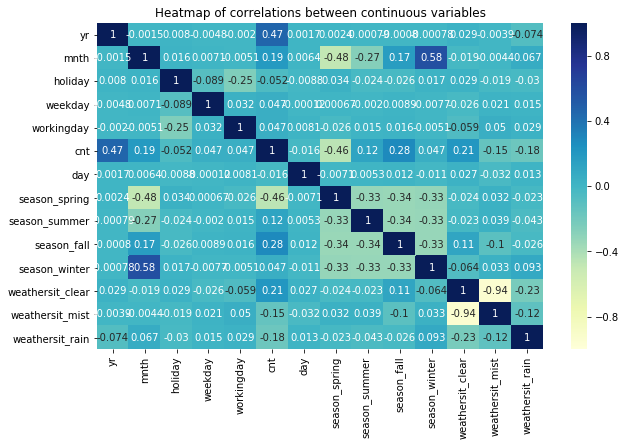

In [10]:
# create a correlation matrix
bike_df_corr_cat = bike_df.drop(columns=['temp', 'atemp', 'windspeed', 'hum', 'casual', 'registered'], axis=1)
bike_df_corr_cat = bike_df_corr_cat.corr(method='kendall')

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr_cat, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


##### Season

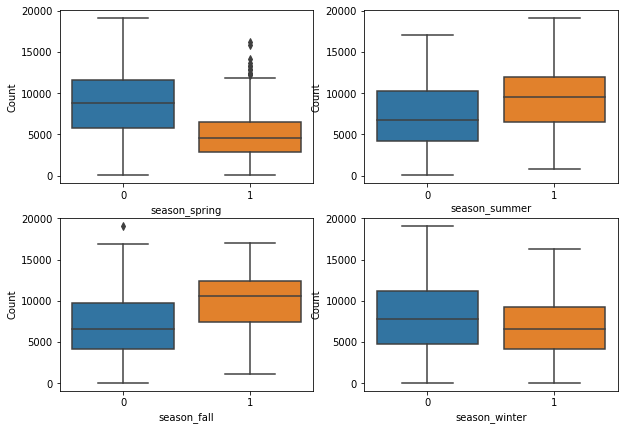

In [241]:
# variable to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall', 'season_winter']

# plotting the seasons vs. number of users in a boxplot
fig, ax = plt.subplots(2, 2, figsize = [10, 7])

count = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 1 and i == 2:
            break
        else:
            ax[j][i] = sb.boxplot(data = bike_df, x = season_names[count], y = 'total_cust', ax=ax[j][i])
            ax[j][i].set_ylabel('Count')
            ax[j][i].set_xlabel(season_names[count])
            
        count += 1


The season feature clearly determines the customer demand for bikes, so this feature will be used for the final model.

##### dteday

In [12]:
bike_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,day,season_spring,season_summer,season_fall,season_winter,weathersit_clear,weathersit_mist,weathersit_rain
0,0,1,0,6,0,0.344167,0.363625,0.805833,0.160446,331,654,985,1,1,0,0,0,0,1,0
1,0,1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,2,1,0,0,0,0,1,0
2,0,1,0,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,3,1,0,0,0,1,0,0
3,0,1,0,2,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,4,1,0,0,0,1,0,0
4,0,1,0,3,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,5,1,0,0,0,1,0,0


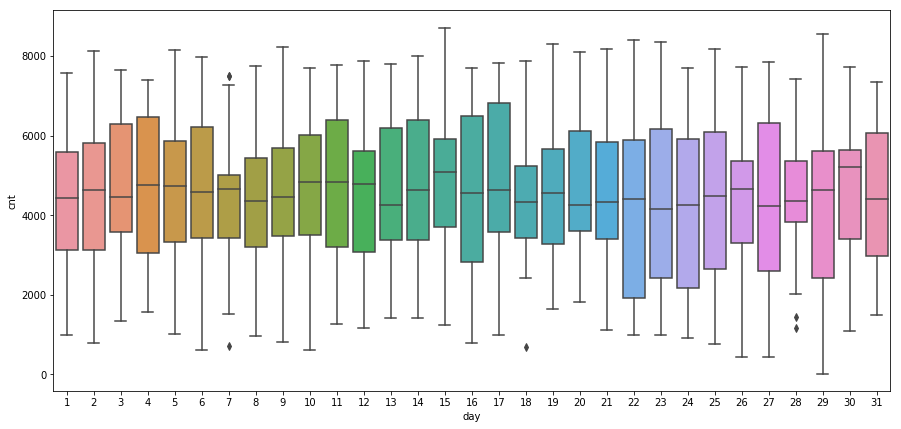

In [13]:
# plot number of users per day of month
plt.figure(figsize=[15,7])
sb.boxplot(x='day', y='cnt', data=bike_df);


There are slight differences in the average numbers of customers per day of the month. Certain days may be more predictive than others of the target variable. I will keep this variable for my model.

##### yr

In [14]:
# split dataframe into two years
yr_2011 = bike_df[bike_df['yr'] == 0]
yr_2012 = bike_df[bike_df['yr'] == 1]

x_2011 = yr_2011.groupby('mnth')['cnt'].mean().index
y_2011 = yr_2011.groupby('mnth')['cnt'].mean().values

x_2012 = yr_2012.groupby('mnth')['cnt'].mean().index
y_2012 = yr_2012.groupby('mnth')['cnt'].mean().values


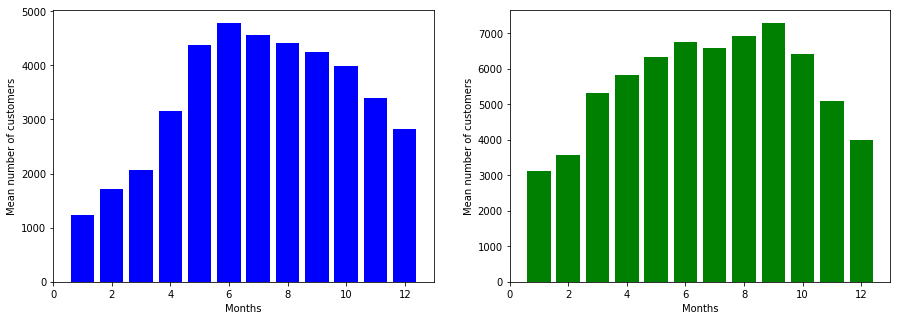

In [15]:
# plot count of customers for each year
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
plt.bar(x_2011, y_2011, color='blue')
plt.xlabel('Months')
plt.ylabel('Mean number of customers')

plt.subplot(1, 2, 2)
plt.bar(x_2012, y_2012, color='green')
plt.xlabel('Months')
plt.ylabel('Mean number of customers');


The distribution of customers per month depends on the year. Thus, the feature yr should be kept for the final model.

##### mnth

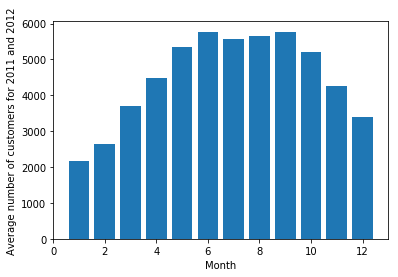

In [16]:
# plotting the total number of customers per month as a sum of both 2011 and 2012
mean_cnt_per_mnth = bike_df.groupby('mnth')['cnt'].mean()
x = mean_cnt_per_mnth.index
y = mean_cnt_per_mnth.values

plt.bar(x, y)
plt.xlabel('Month')
plt.ylabel('Average number of customers for 2011 and 2012');


The mnth feature shows differences in the average number of customers per month.

##### holiday

The features holiday, weekday and workingday have some overlaps in their prediction of customer demand, thus, I will first analyze each individual feature and then investigate their correlation.

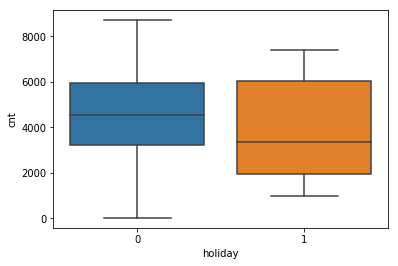

In [17]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data = bike_df, x = 'holiday', y = 'cnt');


For the holiday feature, we can clearly see that there is on average a higher demand for bikes on days that are not holidays. This feature will be used in the final model to predict the overall demand.

In [18]:
# Correlation between holiday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['holiday'], bike_df['cnt'])


KruskalResult(statistic=1237.4880012085603, pvalue=4.347245310989954e-271)

##### weekday

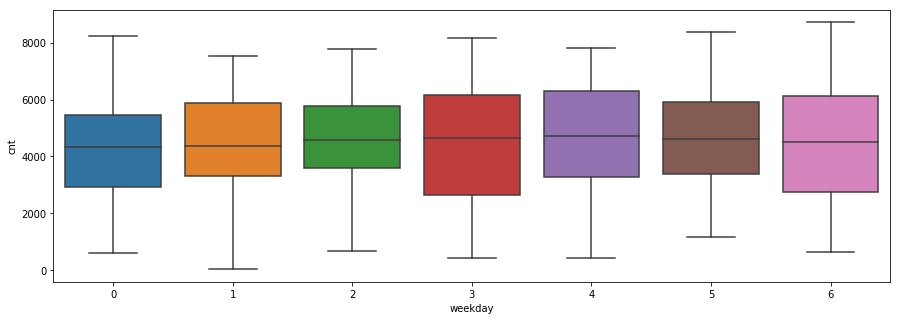

In [19]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize = [15, 5])
sb.boxplot(data = bike_df, x = 'weekday', y = 'cnt');


In [20]:
# Correlation between weekday feature and the number of customers per day
# using Pearson's correlation coefficient because I'm assuming that weekday can be 
# considered a continuous variable
pearsonr(bike_df['weekday'], bike_df['cnt'])


(0.06744341241063048, 0.06839080695470057)

Based on the above distributions of number of customers per weekday, it appears that there are slight difference in demand depending on what weekday it is. Thus, the weekday will be considered to forecast the bike demand.

##### workingday

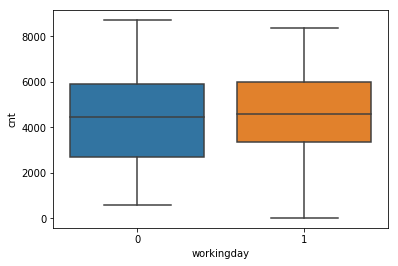

In [21]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x = 'workingday', y = 'cnt');


In [22]:
# Correlation between workingday feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
kruskal(bike_df['workingday'], bike_df['cnt'])


KruskalResult(statistic=1146.116725279893, pvalue=3.1322962418621962e-251)

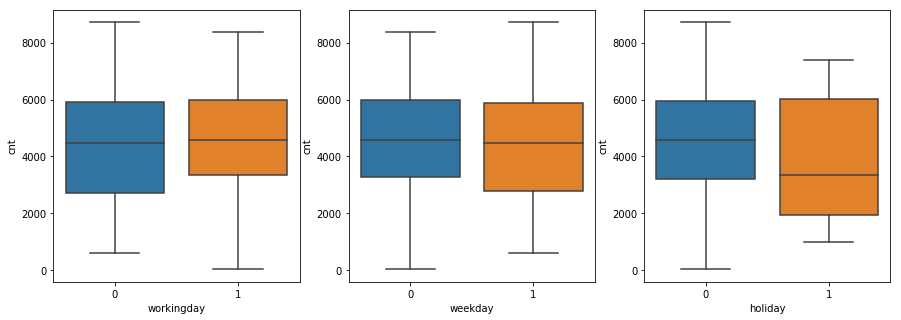

In [23]:
# create a new dataframe that encodes the weekday feature with 0 for monday through friday
# and 1 for saturday and sunday
weekend_distinct_df = bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

# plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'workingday', y = 'cnt');

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = weekend_distinct_df, x = 'weekday', y = 'cnt');

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'holiday', y = 'cnt');


In [24]:
# plot the means of each instance of workingday
bike_df.groupby('workingday')['cnt'].mean()


workingday
0    4330.168831
1    4584.820000
Name: cnt, dtype: float64

In [25]:
# plot the means of each instance of weekday
weekend_distinct_df.groupby('weekday')['cnt'].mean()


weekday
0    4550.566219
1    4389.685714
Name: cnt, dtype: float64

In [26]:
# plot the means of each instance of holiday
bike_df.groupby('holiday')['cnt'].mean()


holiday
0    4527.104225
1    3735.000000
Name: cnt, dtype: float64

The features holiday, weekday and workingday are correlated with each other as well as with the target variable cnt. However, they contain slightly different information that may be useful for predicting the target variable. Thus, I will keep all three variables for my model.

##### weathersit

The feature weathersit contains the following returns and meanings:
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

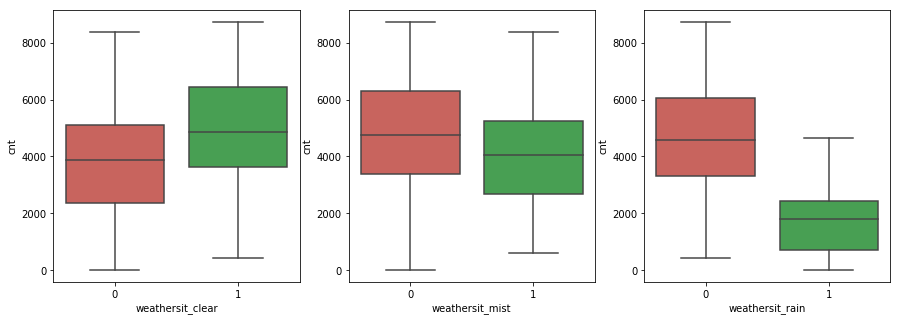

In [27]:
# plotting the weathersit vs. number of users in a boxplot
plt.figure(figsize = [15, 5])

# boxplot for feature workingday
plt.subplot(1, 3, 1)
sb.boxplot(data = bike_df, x = 'weathersit_clear', y = 'cnt',
          palette=[sb.xkcd_rgb["pale red"], sb.xkcd_rgb["medium green"]]);

# boxplot for feature weekday
plt.subplot(1, 3, 2)
sb.boxplot(data = bike_df, x = 'weathersit_mist', y = 'cnt',
          palette=[sb.xkcd_rgb["pale red"], sb.xkcd_rgb["medium green"]]);

# boxplot for feature holiday
plt.subplot(1, 3, 3)
sb.boxplot(data = bike_df, x = 'weathersit_rain', y = 'cnt',
          palette=[sb.xkcd_rgb["pale red"], sb.xkcd_rgb["medium green"]],);


As expected, the weathersit feature has a strong influence on the number of customers. 

#### Continuous variables

granger causality
lagged data

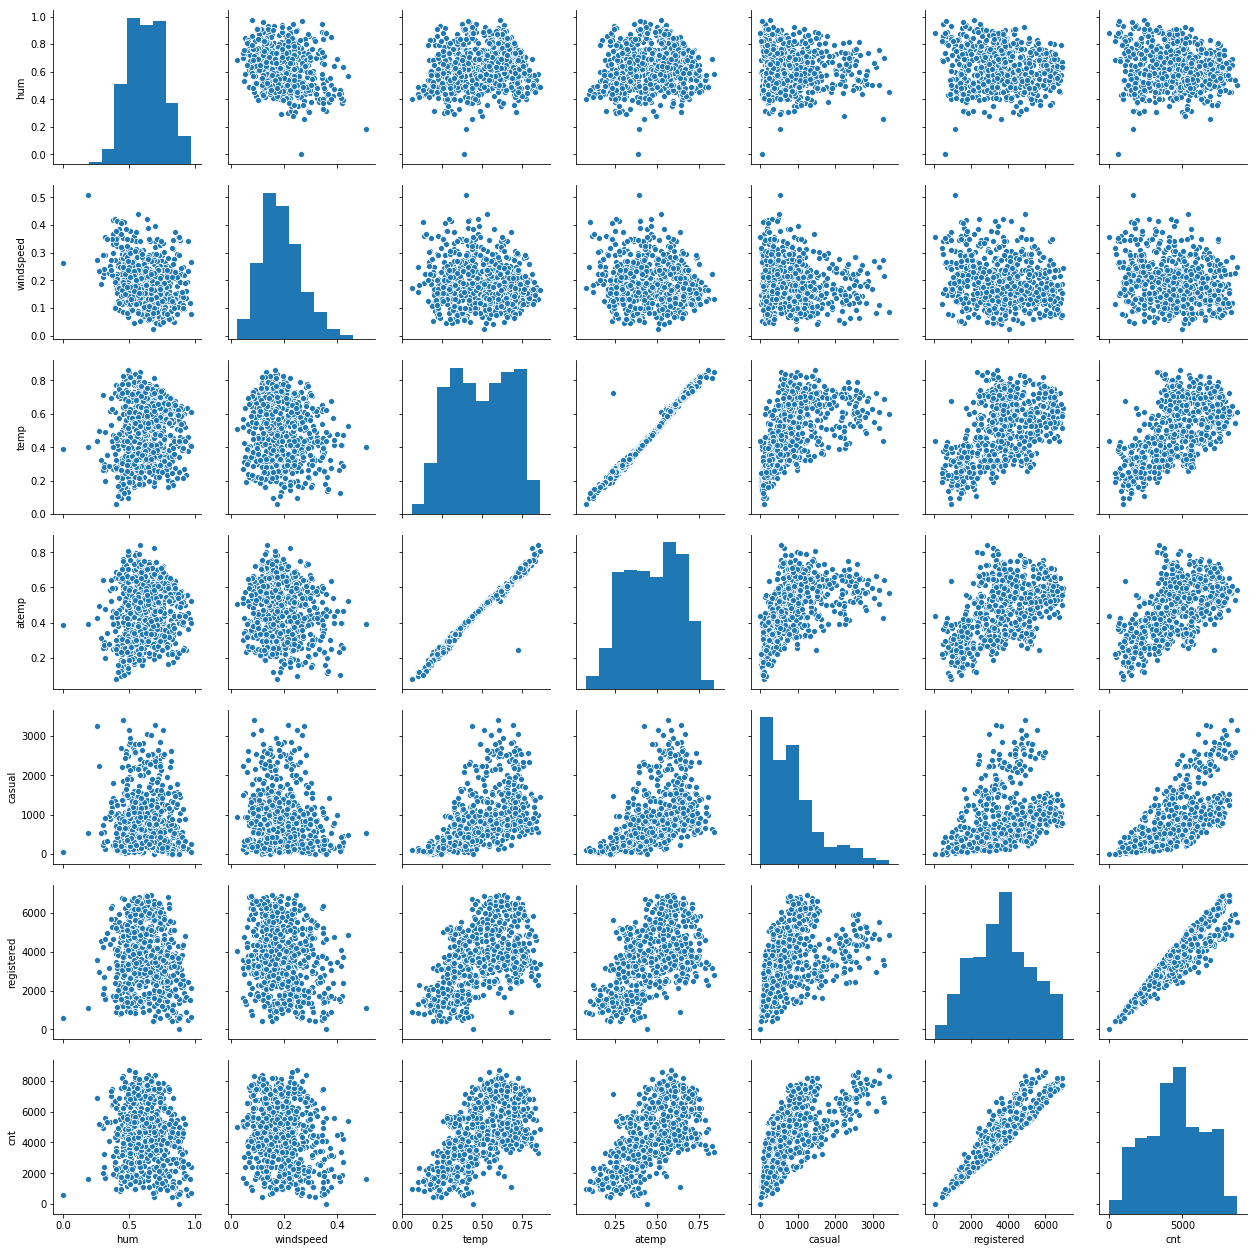

In [28]:
# plot all distributions and scatterplot between each continuous variable pair
sb.pairplot(bike_df, vars=['hum', 'windspeed', 'temp', 'atemp', 'casual', 'registered', 'cnt']);


Based on the results of the above pairplot, the following things are apparent:
* there does not seem to be a **linear relationship between hum and cnt**
* **casual is a left-skewed** variable and would need to be log transformed
* **windspeed looks like a Weibull distribution**
* there is an almost **perfect linear relationship between atemp and temp**
* there exists a **linear relationship between registered and cnt**
* **casual and cnt** are related through a **logarithmic function**
* **temp and atemp** also have a **linear relationship with cnt**
* **hum and windspeed** seem to be **not very determinative of cnt**


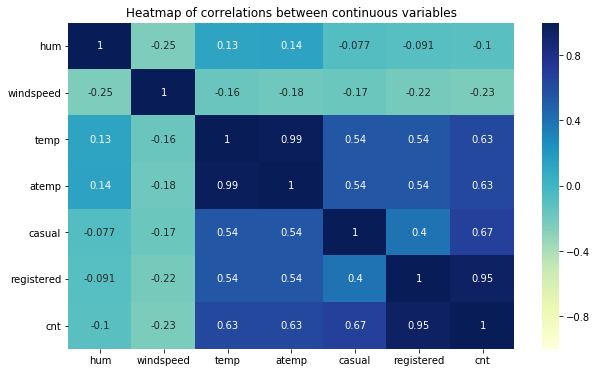

In [29]:
# create a correlation matrix
bike_df_corr = bike_df[['hum', 'windspeed', 'temp', 'atemp', 'casual', 'registered', 'cnt']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True,
          vmin=-1, vmax=1, center=0,
          cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables');


The heatmap underlines the indications of the pairplot and a number of steps need to be taken:
* atemp is perfectly correlated with temp, thus, atemp will be dropped from our dataset
* registered and casual are subsets of the cnt variables and do not lead to additional information, but rather to leakage, thus, both features will be dropped from the dataset
* hum and windspeed are only weakly, linearly correlated with cnt, however, I will keep them


##### temp

In [30]:
# create series that groups the mean temperature per month
temp_per_month = bike_df.groupby('mnth')['temp'].mean()
temp_per_month


mnth
1     0.236444
2     0.299226
3     0.390539
4     0.469999
5     0.594798
6     0.684097
7     0.755470
8     0.708582
9     0.616485
10    0.485012
11    0.369220
12    0.324031
Name: temp, dtype: float64

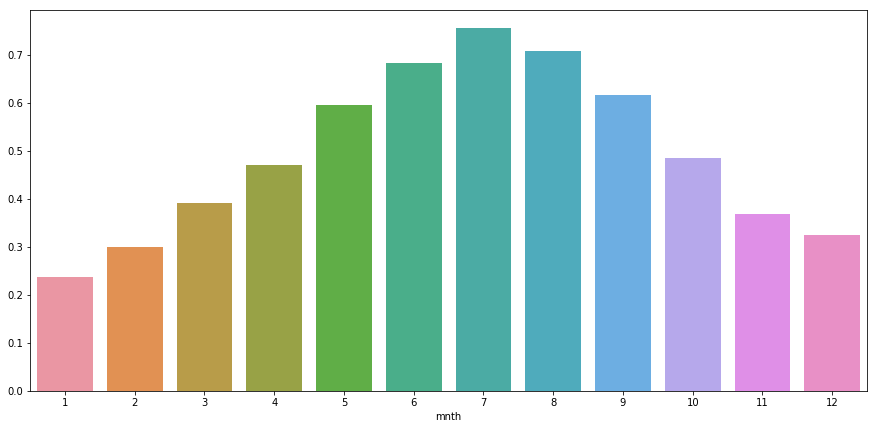

In [31]:
# plot number of users per day of month
plt.figure(figsize=[15,7])
sb.barplot(x=temp_per_month.index, y=temp_per_month.values);

In [32]:
# create series that groups average users per month
mean_cnt_per_mnth = bike_df.groupby('mnth')['cnt'].mean()
mean_cnt_per_mnth


mnth
1     2176.338710
2     2655.298246
3     3692.258065
4     4484.900000
5     5349.774194
6     5772.366667
7     5563.677419
8     5664.419355
9     5766.516667
10    5199.225806
11    4247.183333
12    3403.806452
Name: cnt, dtype: float64

<Figure size 1080x504 with 0 Axes>

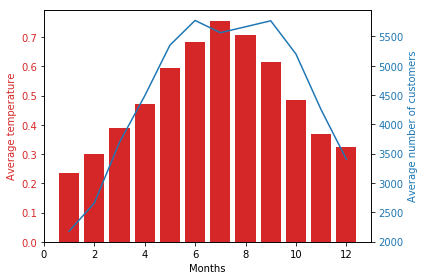

In [33]:
# assign x and y1 and y2
x = list(temp_per_month.index)
y1 = temp_per_month.values
y2 = mean_cnt_per_mnth.values

# below code adapted from https://matplotlib.org/gallery/api/two_scales.html
# creat plot containing both average count of customers
# and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Months')
ax1.set_ylabel('Average temperature', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average number of customers', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout() 
plt.show()


From the above graph we can see that the month variable is correlated with the average number of customers per that month as well as the average temperature. The temperature strongly determines the number of customers. The temperature is likely a very important feature for predicting the target variable.

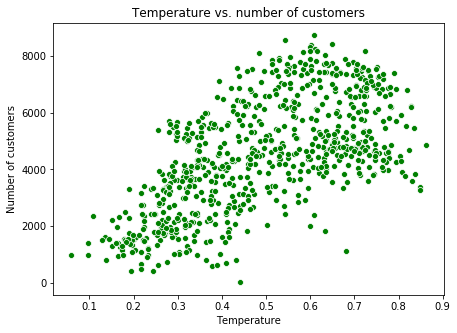

In [43]:
# plotting temp feature against the target label cnt
plt.figure(figsize=[7,5])

sb.scatterplot(data = bike_df, x = 'temp', y = 'cnt', color='green')
plt.xlabel('Temperature')
plt.ylabel('Number of customers')
plt.title('Temperature vs. number of customers');



##### hum

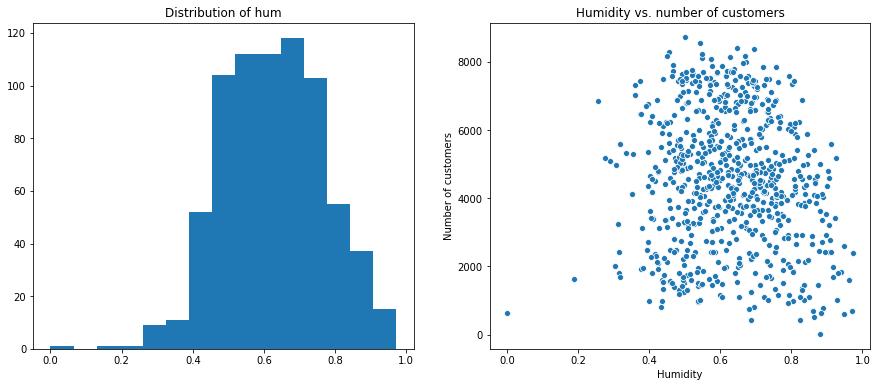

In [44]:
# plotting the distribution of hum
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['hum'], bins=15)
plt.title('Distribution of hum')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'hum', y = 'cnt')
plt.xlabel('Humidity')
plt.ylabel('Number of customers')
plt.title('Humidity vs. number of customers');

Although hum is only correlated with cnt in a weak sense, I will keep this in the model.

##### windspeed

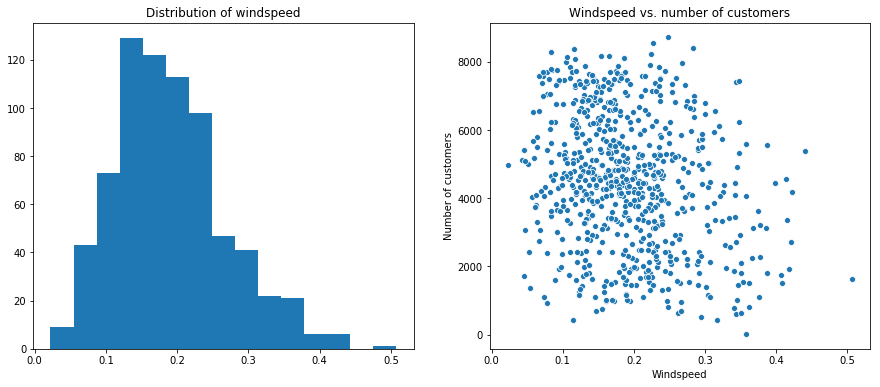

In [35]:
# plotting the distribution of windspeed
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['windspeed'], bins=15)
plt.title('Distribution of windspeed')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'windspeed', y = 'cnt')
plt.xlabel('Windspeed')
plt.ylabel('Number of customers')
plt.title('Windspeed vs. number of customers');



Although windspeed is only correlated with cnt in a weak sense, similar to hum, I will keep this in the model.

##### cnt

#### 2.4. Feature Selection

It is important to avoid look ahead bias and not to consider any features or data that we can only know in the future to predict the future. Checking this bias for all features that are still in the dataset:
* yr: not relevant for lookahead bias
* mnth: not relevant for lookahead bias
* holiday: no lookahead bias
* weekday: no lookahead bias
* workingday: no lookahead bias
* temp: temperature has some lookahead bias but we can use the forecast to know what the weather will most likely look like; only works a couple days in the future, not a month, for example
* hum: similar to temperature
* day: not relevant to lookahead bias
* season_spring: no lookahead bias
* season_summer: no lookahead bias
* season_fall: no lookahead bias
* season_winter: no lookahead bias
* weathersit_clear: similar to temperature
* weathersit_mist: similar to temperature
* weathersit_rain: similar to temperature
* windspeed: similar to temperature


In [36]:
# drop columns that should not be used in our model
bike_df.drop(columns=['atemp', 'registered', 'casual'], axis=1, inplace=True)


In [37]:
bike_df.head()

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,cnt,day,season_spring,season_summer,season_fall,season_winter,weathersit_clear,weathersit_mist,weathersit_rain
0,0,1,0,6,0,0.344167,0.805833,0.160446,985,1,1,0,0,0,0,1,0
1,0,1,0,0,0,0.363478,0.696087,0.248539,801,2,1,0,0,0,0,1,0
2,0,1,0,1,1,0.196364,0.437273,0.248309,1349,3,1,0,0,0,1,0,0
3,0,1,0,2,1,0.200000,0.590435,0.160296,1562,4,1,0,0,0,1,0,0
4,0,1,0,3,1,0.226957,0.436957,0.186900,1600,5,1,0,0,0,1,0,0


Add additional dataset --> need to research papers and decide what to add

Use PCA maybe?

### 3. Data Preparation

In [ ]:
# read in dataset
bike_df = pd.read_csv('bike-sharings.csv')


In [ ]:
# define cleaning function to prepare the data
def clean(df):
    '''
    Function to clean and prepare a dataset for machine learning models
    Args: df = dataframe
    Returns: X = dataframe containing features
             y = vector containing target labels
    '''
    
    # create new column with day of the month
    bike_df['day'] = bike_df['dteday'].apply(lambda x: x[-2:])
    bike_df['day'] = bike_df['day'].astype('int64')
    
    
    # drop features that are unnecessary for the model
    bike_df.drop(columns=['dteday'], axis=1, inplace=True)
    
    # assign X and y
    y = bike_df['cnt']
    X = bike_df.drop(columns=['cnt'], axis=1)
    
    return X, y


### 4. Model

Be careful --> this is time series data so I need to be careful when splitting the dataset

I may not need to split it when using pipelines, but I need to research how to do this

My pipeline should include ALL transformations, including onehot encoding, that I make after the very initial cleaning of data. Thus, I need to read in my data again after the EDA process.

If I'm using gradient descent I most DEFINITELY need to convert month and year to categorical features

my model needs to use the cnt of today and check how the weather of the previous week predicted cnt

or I could use the forecast of today and see how the forecast predicted the cnt

day 1 day 2 day 3 day 4 day 5 day 6 day 7 --> predict cnt of day 8

look at the mean and standard deviation of the 


#### 4.1. Stochastic Gradient Descent

In [39]:
# defining the hyperparameters
hyperparams = {'loss': 'log', 'penalty': 'none', 'alpha': 0.0001, 'max_iter': 1000, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.0001}

# initializing the model which is a Stochastic Gradient Descent model
model = SGDClassifier(**hyperparams)


In [58]:
# create ML pipeline
features_standard_scaler = [x for x in list(X.columns) if x not in ['temp', 'hum', 'windspeed']]
transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('transformer', transformer, features_standard_scaler)
])

# pipeline that runs the preprocessor pipeline and then applies the model to the data set
pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', model)
])

# fit the data to the result of the pipeline above
pipeline = pipeline.fit(X, y)



#### 4.2. XGBoost

#### 4.3. AdaBoost

#### 4.4. LightGBM

### 5. Evaluation